# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [375]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow seaborn

In [376]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg
from IPython.display import display

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

# Imports for question 2 onwards
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

plt.ion()
warnings.filterwarnings('ignore')
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [377]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [378]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [379]:
# Loading the dataset
# eg.
dirpaths = ['./dataset/Yale_face_database/', './dataset/IMFDB/', './dataset/IIIT-CFW/']
dataset_names = ['Yale', 'IMFDB', 'CFW']
dirpath = './dataset/Yale_face_database/'
X1, y1 = load_data(dirpath)
N1, H, W = X1.shape[0:3]
C = 1 if opt['is_grayscale'] else X1.shape[3]

dirpath = './dataset/IMFDB/'
X2, y2 = load_data(dirpath)
N2, H, W = X2.shape[0:3]

dirpath = './dataset/IIIT-CFW/'
X3, y3 = load_data(dirpath)
N3, H, W = X3.shape[0:3]

dirpath = './dataset/IMFDB/'
X, y = load_data(dirpath)
N, H, W = X.shape[0:3]

Dataset shape: (165, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)


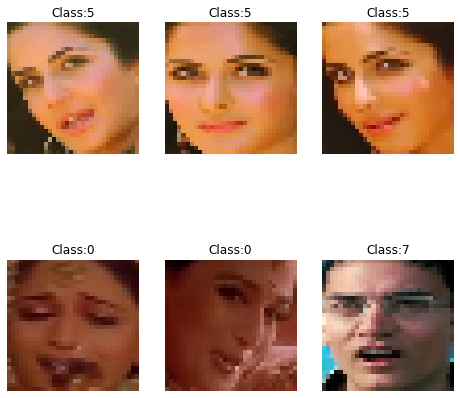

In [380]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [381]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

In [409]:
# Flatten all data
X1 = X1.reshape((N1,H*W*C))
X2 = X2.reshape((N2,H*W*C))
X3 = X3.reshape((N3,H*W*C))

X_all = [X1, X2, X3]
y_all = [y1, y2, y3]
N_all = [N1, N2, N3]

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [478]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
#     return X_k
#     pca.fit(X)
    return X_k, pca

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [384]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    X_k = kpca.fit_transform(X)
    return X_k, kpca

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [385]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k, lda

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [386]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    return X_k, klda

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [387]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [388]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

__________________________

Eigenfaces is the name given to a set of eigenvectors when they are used in the computer vision problem of human face recognition.

1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

In [497]:
# Compute your features 
# eg.
X_proj = [None, None, None]
num_eig = [61, 123, 308]
pca = [None, None, None]
for i in range(3):
    X_proj[i], pca[i] = get_pca(X_all[i], num_eig[i])

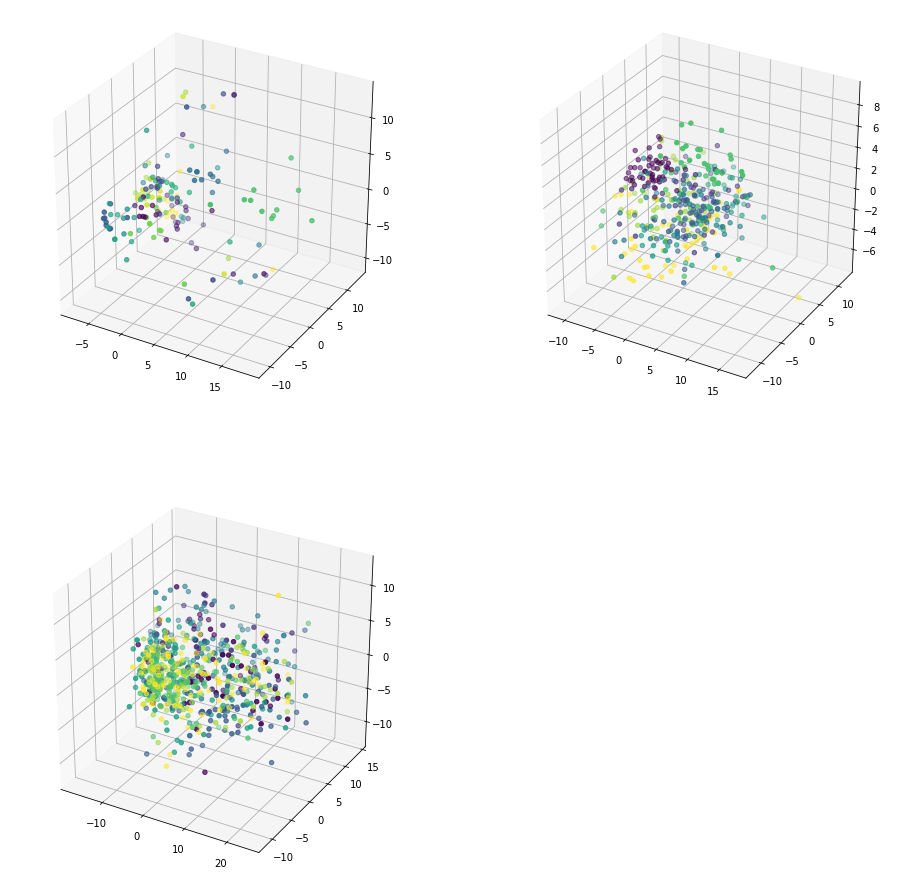

In [498]:
# Create a scatter plot  
# eg.
temp = 221
fig = plt.figure(figsize=(16, 16))
for i in range(3):
    ax = fig.add_subplot(temp, projection='3d')
    temp += 1
    ax.scatter(X_proj[i][:,0],X_proj[i][:,1],X_proj[i][:,2],c=y_all[i])

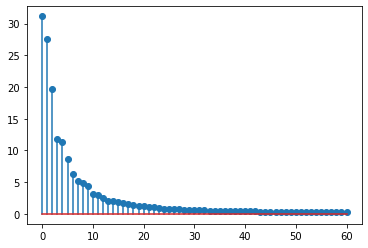

In [499]:
# Plot the eigen value spectrum for Yale Dataset
eigvals = pca[0].explained_variance_
plt.stem(eigvals)
plt.savefig('./images/eig_spectrum_yale')

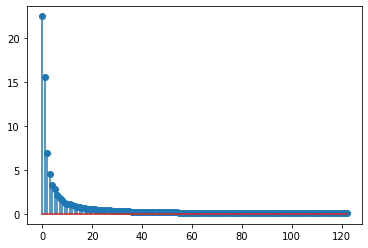

In [500]:
# Plot the eigen value spectrum for CFW Dataset
eigvals = pca[1].explained_variance_
plt.stem(eigvals)
plt.savefig('./images/eig_spectrum_CFW')

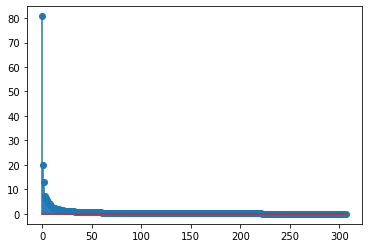

In [501]:
# Plot the eigen value spectrum for IMDB Dataset
eigvals = pca[2].explained_variance_
plt.stem(eigvals)
plt.savefig('./images/eig_spectrum_IMDB')

1(c). Reconstruct  the  image  back for each case


In [502]:
def reconstruct_images(X, red_X, k, pca):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
#     print(X.shape, red_X.shape)
#     if feature_type == 'pca':
    #     temp, pca = get_pca(X, k)
    reconstruct_X = pca.inverse_transform(red_X)
    
    return reconstruct_X

### Yale Dataset

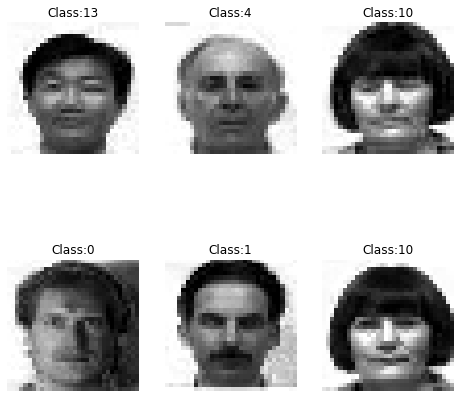

0.05450172250919538


In [503]:
# Display results 
X_reconstructed = reconstruct_images(X_all[0], X_proj[0], num_eig[0], pca[0])

#reshape
X_reconstructed = X_reconstructed.reshape((N_all[0], H, W, C))

# Display random images
ind = np.random.randint(0,y_all[0].shape[0],6)
disply_images(X_reconstructed[ind,...],y_all[0][ind],row=2,col=3)

#reshape
X_reconstructed = X_reconstructed.reshape((N_all[0], H*W*C))

# Show the reconstruction error
print(np.sqrt(np.mean((X_all[0] - X_reconstructed)**2)))

### IMDB Dataset

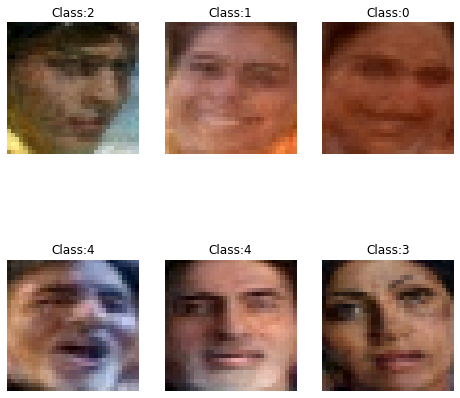

0.03878930804638328


In [504]:
# Display results 
X_reconstructed = reconstruct_images(X_all[1], X_proj[1], num_eig[1], pca[1])

#reshape
X_reconstructed = X_reconstructed.reshape((N_all[1], H, W, C))

# Display random images
ind = np.random.randint(0,y_all[1].shape[0],6)
disply_images(X_reconstructed[ind,...],y_all[1][ind],row=2,col=3)

#reshape
X_reconstructed = X_reconstructed.reshape((N_all[1], H*W*C))

# Show the reconstruction error
print(np.sqrt(np.mean((X_all[1] - X_reconstructed)**2)))

### CFW Dataset

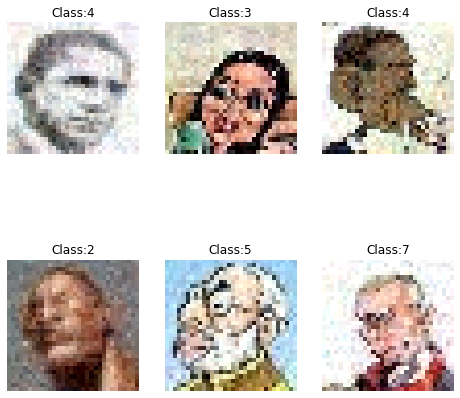

0.0684142095399651


In [505]:
# Display results 
X_reconstructed = reconstruct_images(X_all[2], X_proj[2], num_eig[2], pca[2])

#reshape
X_reconstructed = X_reconstructed.reshape((N_all[2], H, W, C))

# Display random images
ind = np.random.randint(0,y_all[2].shape[0],6)
disply_images(X_reconstructed[ind,...],y_all[2][ind],row=2,col=3)

#reshape
X_reconstructed = X_reconstructed.reshape((N_all[2], H*W*C))

# Show the reconstruction error
print(np.sqrt(np.mean((X_all[2] - X_reconstructed)**2)))

1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

In [509]:
# code goes here
max_error = 0
max_error_class = 0
for i in range(3):
    for yi in np.unique(y_all[i]):
        ind = np.where(y_all[i] == yi)
        tempx = X_all[i][ind]
        tempxproj = X_proj[i][ind]
        X_reconstructed = reconstruct_images(tempx, tempxproj, num_eig[i], pca[i])
        error = np.sqrt(np.mean((X_all[i][ind] - X_reconstructed)**2))
        if error > max_error:
            max_error = error
            max_error_class = yi
    print(dataset_names[i], max_error_class)

Yale 14
IMFDB 14
CFW 1


2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [510]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 
class Classifier():
    def __init__(self, model):
        self.model = model
        
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self, X):
        """
            Given an input X classify it into appropriate class. 
        """
        prediction = self.model.predict(X)
        return prediction
        
    def confusion_matrix(self, pred, y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        return confusion_matrix(y, pred)
        
    def train(self, X_train, y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.model = self.model.fit(X_train, y_train)
        
    def validate(self, X_validate, y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        prediction = self.classify(X_validate)
        # Create a confusion matrix
        cm = self.confusion_matrix(prediction, y_validate)
        # Calculate Validation accuracy 
        accuracy = accuracy_score(y_validate, prediction)
        # Calculate precision and recall
        precision = precision_score(y_validate, prediction, average='weighted')
        recall = recall_score(y_validate, prediction, average='weighted')
        # Calculate F1-score
        f1 = f1_score(y_validate, prediction, average='weighted')
        return prediction, cm, accuracy, precision, recall, f1

In [511]:
# Create a train and validation split to train your classifier
# Create models for MLP, Logistic regression, SVM, Decision Trees

mlp_model = Classifier(MLPClassifier(hidden_layer_sizes=(300, 150, 30)))
logistic_reg_model = Classifier(LogisticRegression(solver='lbfgs', multi_class='auto'))
svm_model_rbf = Classifier(SVC(gamma='scale'))
dtree_model = Classifier(DecisionTreeClassifier())
models = [mlp_model, logistic_reg_model, svm_model_rbf, dtree_model]
model_names = ['MLP', 'Logistic Regression', 'SVM', 'D-Tree']
features = ['PCA', 'Kernel PCA', 'LDA', 'Kernel LDA', 'VGG', 'ResNet']

In [520]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score
cm_for_best = [0, 0, 0]
threshold = [0.95, 0.8, 0.8]
lp = []
for idx in range(3):
    X_train_list = []
    X_test_list = []
    y_train_list = []
    y_test_list = []
    num_features = 10
    X_train, X_test, y_train, y_test = train_test_split(X_all[idx], y_all[idx], random_state = 0)

    temp, pca = get_pca(X_train, num_features)
    X_train_list.append(temp)
    X_test_list.append(pca.transform(X_test))
    y_train_list.append(y_train)
    y_test_list.append(y_test)

    temp, kpca = get_kernel_pca(X_train, num_features)
    X_train_list.append(temp)
    X_test_list.append(kpca.transform(X_test))
    y_train_list.append(y_train)
    y_test_list.append(y_test)

    temp, lda = get_lda(X_train, y_train, num_features)
    X_train_list.append(temp)
    X_test_list.append(lda.transform(X_test))
    y_train_list.append(y_train)
    y_test_list.append(y_test)

    temp, klda = get_kernel_lda(X_train, y_train, num_features)
    X_train_list.append(temp)
    X_test_list.append(klda.transform(X_test))
    y_train_list.append(y_train)
    y_test_list.append(y_test)

    vggx = get_vgg_features(dirpaths[idx])
    X_train, X_test, y_train, y_test = train_test_split(vggx, y_all[idx], random_state = 0)
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

    resnetx = get_resnet_features(dirpaths[idx])
    X_train, X_test, y_train, y_test = train_test_split(resnetx, y_all[idx], random_state = 0)
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)
    c1 = []
    c2 = []
    c3 = []
    c4 = []
    c5 = []
    accuracy_max = 0
    for i, feature in enumerate(features):
        for j, model_name in enumerate(model_names):
            model = models[j]
            model.train(X_train_list[i], y_train_list[i])
            prediction, cm, accuracy, p, r, f1 = model.validate(X_test_list[i], y_test_list[i])
            if accuracy > accuracy_max:
                cm_for_best[idx] = cm
            if accuracy > threshold[idx]:
                c1.append(feature + '/' + model_name)
                c2.append((X_train_list[i].shape)[1])
                c3.append(round(1 - accuracy, 2))
                c4.append(round(accuracy, 2))
                c5.append(round(f1, 2))
    # Print the table. (You can use Pandas)
    df = pd.DataFrame({'Feat./Modl.' : c1,
                       'Red. Dim.' : c2,
                       'Error' : c3,
                       'Accu.' : c4,
                       'f1-s.' : c5,
                      })
    print("=================================== " + dataset_names[idx] + " ===================================")
    display(df)
    lp.append(df)
    print("================================= END =======================================")
lp[0].to_csv(r'./csv/accuracy_yale.csv', index=None, header=True)
lp[1].to_csv(r'./csv/accuracy_imdb.csv', index=None, header=True)
lp[2].to_csv(r'./csv/accuracy_cfw.csv', index=None, header=True)

=================================== Yale ===================================


,Feat./Modl.,Red. Dim.,Error,Accu.,f1-s.
0,LDA/MLP,10,0.02,0.98,0.98
1,LDA/Logistic Regression,10,0.00,1.00,1.00
2,Kernel LDA/Logistic Regression,10,0.00,1.00,1.00
3,ResNet/MLP,2048,0.02,0.98,0.98
4,ResNet/Logistic Regression,2048,0.02,0.98,0.98
5,ResNet/SVM,2048,0.02,0.98,0.98


================================= END =======================================
=================================== IMFDB ===================================


,Feat./Modl.,Red. Dim.,Error,Accu.,f1-s.
0,VGG/MLP,4096,0.13,0.87,0.87
1,VGG/Logistic Regression,4096,0.12,0.88,0.88
2,VGG/SVM,4096,0.13,0.87,0.87
3,ResNet/MLP,2048,0.06,0.94,0.94
4,ResNet/Logistic Regression,2048,0.07,0.93,0.93
5,ResNet/SVM,2048,0.07,0.93,0.93
6,ResNet/D-Tree,2048,0.13,0.87,0.87


================================= END =======================================
=================================== CFW ===================================


,Feat./Modl.,Red. Dim.,Error,Accu.,f1-s.
0,ResNet/MLP,2048,0.04,0.96,0.96
1,ResNet/Logistic Regression,2048,0.04,0.96,0.96
2,ResNet/SVM,2048,0.04,0.96,0.96
3,ResNet/D-Tree,2048,0.08,0.92,0.92


================================= END =======================================


## Confusion matrix for Yale Dataset

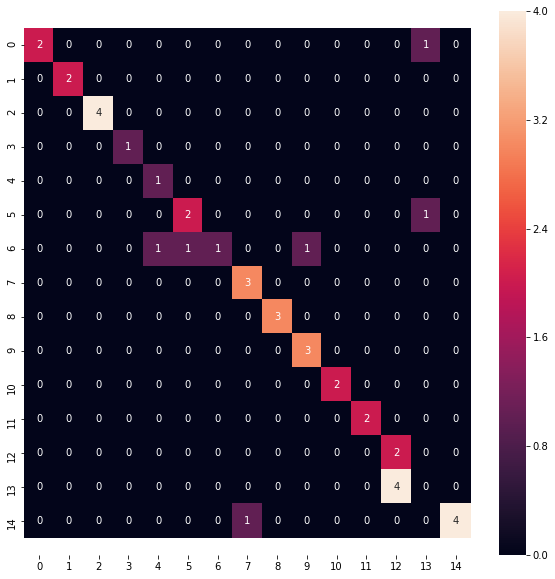

In [514]:
# For each dataset print the confusion matrix for the best model
plt.figure(figsize=(10,10))
ax = sns.heatmap(cm_for_best[0], annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 1, top - 1)
plt.show()

## Confusion matrix for IMDB Dataset

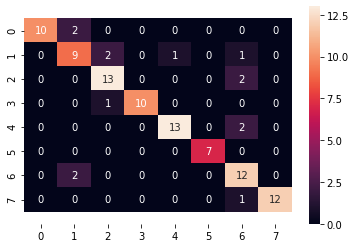

In [515]:
# For each dataset print the confusion matrix for the best model
ax = sns.heatmap(cm_for_best[1], annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 1, top - 1)
plt.show()

## Confusion matrix for CFW Dataset

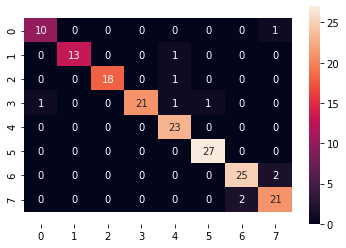

In [516]:
# For each dataset print the confusion matrix for the best model
ax = sns.heatmap(cm_for_best[2], annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 1, top - 1)
plt.show()

3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

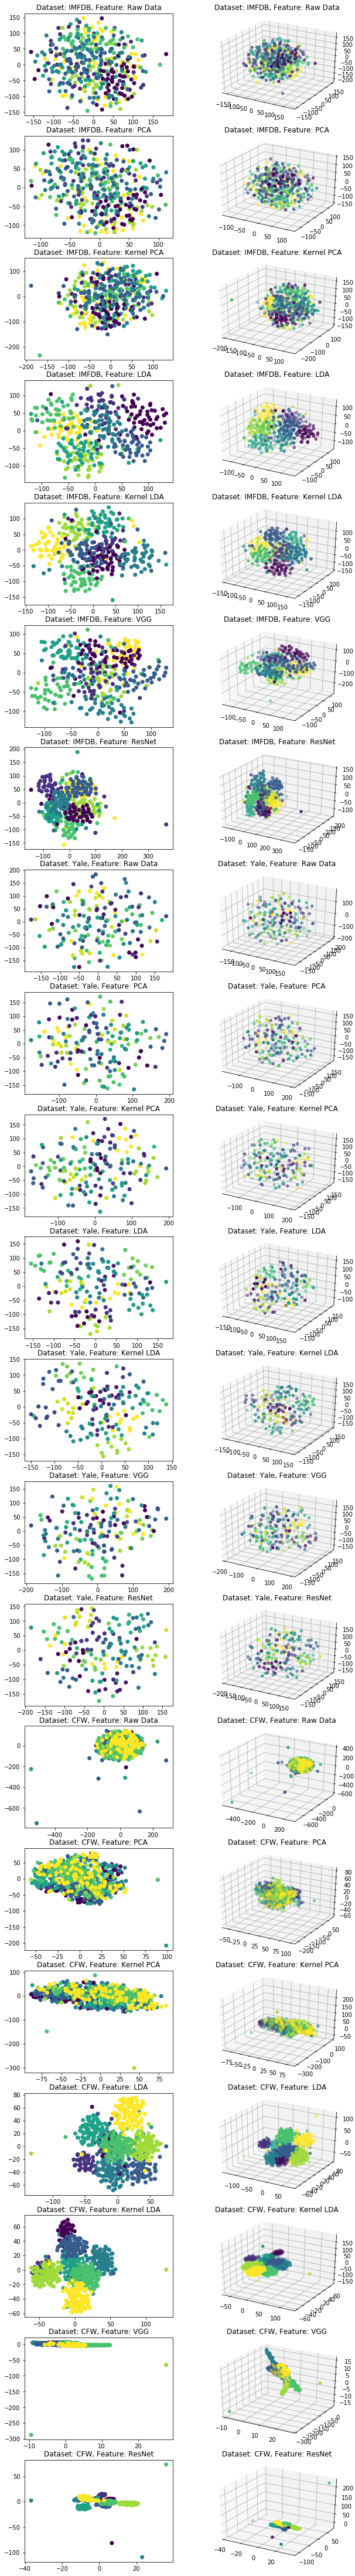

In [424]:
# Compute TSNE for different features and create a scatter plot

k = 3 # Number of components in TSNE
num_features = 10
fig = plt.figure(figsize=(10, 80))
idx = 1
features = ['Raw Data', 'PCA', 'Kernel PCA', 'LDA', 'Kernel LDA', 'VGG', 'ResNet']
for i in [1, 0, 2]:
    X_pca, pca = get_pca(X_all[i], num_features)
    X_kpca, kpca = get_kernel_pca(X_all[i], num_features)
    X_lda, lda = get_lda(X_all[i], y_all[i], num_features)
    X_klda, klda = get_kernel_lda(X_all[i], y_all[i], num_features)
    X_vgg = get_vgg_features(dirpaths[i])
    X_resnet = get_resnet_features(dirpaths[i])
    comp_features = [X_all[i], X_pca, X_kpca, X_lda, X_klda, X_vgg, X_resnet]
    # Compute
    for j, f in enumerate(comp_features):
        X_TSNE = TSNE(n_components=k).fit_transform(f)
        # Plot the representation in 2d/3d
        ax = fig.add_subplot(21, 2, idx)
        idx += 1
        ax.title.set_text("Dataset: " + dataset_names[i] + ", Feature: " + features[j])
        ax.scatter(X_TSNE[:,0],X_TSNE[:,1], c=y_all[i])
        ax = fig.add_subplot(21, 2, idx, projection='3d')
        idx += 1
        ax.title.set_text("Dataset: " + dataset_names[i] + ", Feature: " + features[j])
        ax.scatter(X_TSNE[:,0],X_TSNE[:,1],X_TSNE[:,2],c=y_all[i])

## t-SNE for combined dataset

Dataset shape: (165, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
(1237, 3072) (1237,)


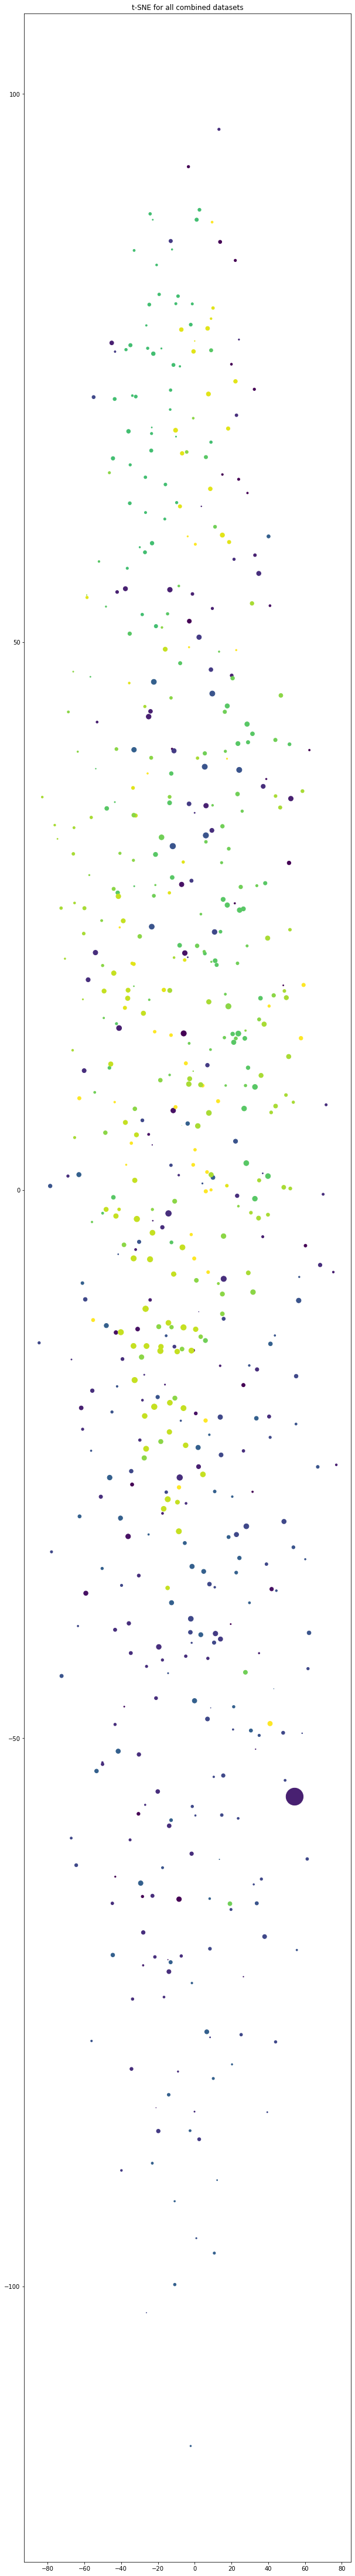

In [579]:
X_yale, y_yale = load_data('./dataset/Yale_face_database')
y_yale += 8

X_cfw, y_cfw =load_data('./dataset/IIIT-CFW')

X_imfdb, y_imfdb = load_data('./dataset/IMFDB')
y_imfdb += 16

X_allt = np.vstack((X_cfw, X_imfdb, X_yale))
y_allt = np.hstack((y_cfw, y_imfdb, y_yale)) 

Nt,Ht,Wt = X_allt.shape[0:3]
Ct = 1 if opt['is_grayscale'] else X_allt.shape[3]
X_allt = X_allt.reshape((Nt,Ht*Wt*Ct))
print(X_allt.shape, y_allt.shape)
# Plot the representation in 2d/3d
Xt = X_allt # feature 
kt = 3 # Number of components in TSNE

# Compute
X_TSNE = TSNE(n_components=kt).fit_transform(Xt)

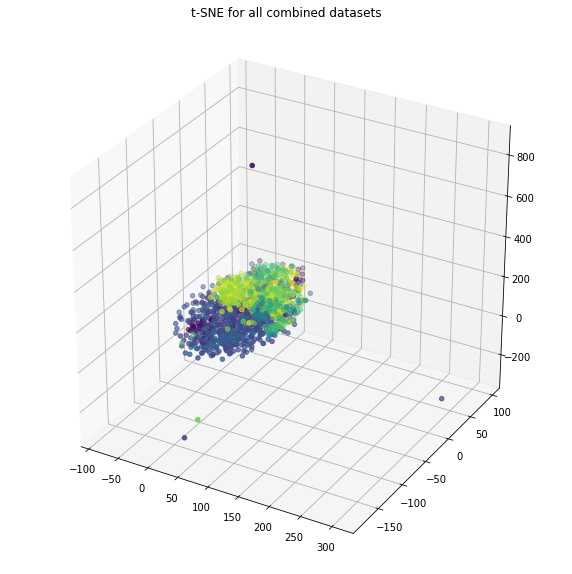

In [581]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.title.set_text("t-SNE for all combined datasets")
ax.scatter(X_TSNE[:,0],X_TSNE[:,1],X_TSNE[:,2],c=y_allt)

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [517]:
class FaceVerification():
    def __init__(self, model):
        self.model = model
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def verify(self, X, class_id):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        verification_results = self.model.predict(X) == class_id
        
        return verification_results
        
    def train(self, X_train, y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.model.fit(X_train, y_train)
        
        
    def validate(self, X_validate, y_validate, y_bool):
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        results = self.verify(X_validate, y_validate)
        accuracy = accuracy_score(y_bool, results)
        precision = precision_score(y_bool, results, average='weighted')
        return round(accuracy, 2), round(precision, 2)

In [522]:
# Create a train and validation split and show your results
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision
# Print the table. (You can use Pandas)

k = 5
faceVer = FaceVerification(KNeighborsClassifier(n_neighbors=k))
lp = []
for idx in range(3):
    X_train_list = []
    X_test_list = []
    y_train_list = []
    y_test_list = []
    y_bool_list = []
    num_features = 10
    X_train, X_test, y_train, y_test = train_test_split(X_all[idx], y_all[idx], random_state = 0)

    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)
    y_bool_list.append([True] * len(y_test))
    
    temp, pca = get_pca(X_train, num_features)
    X_train_list.append(temp)
    X_test_list.append(pca.transform(X_test))
    y_train_list.append(y_train)
    y_test_list.append(y_test)
    y_bool_list.append([True] * len(y_test))

    temp, kpca = get_kernel_pca(X_train, num_features)
    X_train_list.append(temp)
    X_test_list.append(kpca.transform(X_test))
    y_train_list.append(y_train)
    y_test_list.append(y_test)
    y_bool_list.append([True] * len(y_test))
    

    temp, lda = get_lda(X_train, y_train, num_features)
    X_train_list.append(temp)
    X_test_list.append(lda.transform(X_test))
    y_train_list.append(y_train)
    y_test_list.append(y_test)
    y_bool_list.append([True] * len(y_test))
    

    temp, klda = get_kernel_lda(X_train, y_train, num_features)
    X_train_list.append(temp)
    X_test_list.append(klda.transform(X_test))
    y_train_list.append(y_train)
    y_test_list.append(y_test)
    y_bool_list.append([True] * len(y_test))
    

    vggx = get_vgg_features(dirpaths[idx])
    X_train, X_test, y_train, y_test = train_test_split(vggx, y_all[idx], random_state = 0)
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)
    y_bool_list.append([True] * len(y_test))
    

    resnetx = get_resnet_features(dirpaths[idx])
    X_train, X_test, y_train, y_test = train_test_split(resnetx, y_all[idx], random_state = 0)
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)
    y_bool_list.append([True] * len(y_test))
    
    c1 = []
    c2 = []
    c3 = []
    c4 = []
    c5 = []
    for i, feature in enumerate(features):
            faceVer.train(X_train_list[i], y_train_list[i])
            accuracy, precision = faceVer.validate(X_test_list[i], y_test_list[i], y_bool_list[i])
            c1.append(feature)
            c2.append((X_train_list[i].shape)[1])
            c3.append(round(1 - accuracy, 2))
            c4.append(accuracy)
            c5.append(precision)
    # Print the table. (You can use Pandas)
    df = pd.DataFrame({'Fet.' : c1,
                       'Red. Dim.' : c2,
                       'Error' : c3,
                       'Accur.' : c4,
                       'Prec.' : c5,
                      })
    print("============================ " + dataset_names[idx] + " ============================")
    display(df)
    lp.append(df)
    print("================================= END =======================================")
lp[0].to_csv(r'./csv/face_verification_yale.csv', index=None, header=True)
lp[1].to_csv(r'./csv/face_verification_imdb.csv', index=None, header=True)
lp[2].to_csv(r'./csv/face_verification_cfw.csv', index=None, header=True)

============================ Yale ============================


,Fet.,Red. Dim.,Error,Accur.,Prec.
0,PCA,3072,0.17,0.83,1.0
1,Kernel PCA,10,0.29,0.71,1.0
2,LDA,10,0.29,0.71,1.0
3,Kernel LDA,10,0.05,0.95,1.0
4,VGG,10,0.05,0.95,1.0
5,ResNet,4096,0.57,0.43,1.0


================================= END =======================================
============================ IMFDB ============================


,Fet.,Red. Dim.,Error,Accur.,Prec.
0,PCA,3072,0.49,0.51,1.0
1,Kernel PCA,10,0.51,0.49,1.0
2,LDA,10,0.51,0.49,1.0
3,Kernel LDA,7,0.22,0.78,1.0
4,VGG,7,0.22,0.78,1.0
5,ResNet,4096,0.14,0.86,1.0


================================= END =======================================
============================ CFW ============================


,Fet.,Red. Dim.,Error,Accur.,Prec.
0,PCA,3072,0.71,0.29,1.0
1,Kernel PCA,10,0.61,0.39,1.0
2,LDA,10,0.62,0.38,1.0
3,Kernel LDA,7,0.62,0.38,1.0
4,VGG,7,0.62,0.38,1.0
5,ResNet,4096,0.26,0.74,1.0


================================= END =======================================


### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

# Cartoon vs Real images

In [523]:
# Load data
X = np.array([])

dirpath = './dataset/Yale_face_database/'
X1, y1 = load_data(dirpath)
N1, H, W = X1.shape[0:3]
C = 1 if opt['is_grayscale'] else X1.shape[3]
X1 = X1.reshape((N1, H*W*C))
dirpath = './dataset/IMFDB/'
X2, y2 = load_data(dirpath)
N2, H, W = X2.shape[0:3]
X2 = X2.reshape((N2, H*W*C))
dirpath = './dataset/IIIT-CFW/'
X3, y3 = load_data(dirpath)
N3, H, W = X3.shape[0:3]
X3 = X3.reshape((N3, H*W*C))

N = N1 + N2 + N3
X = np.append(X1, X2, axis=0)
X = np.append(X, X3, axis=0)
y = np.append(np.zeros(N1 + N2), np.ones(N3))
print(X.shape, y.shape)

Dataset shape: (165, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
(1237, 3072) (1237,)


In [564]:
num_features = 300
X_kpca, kpca = get_pca(X, num_features)

## t-SNE Plot for the combined dataset.

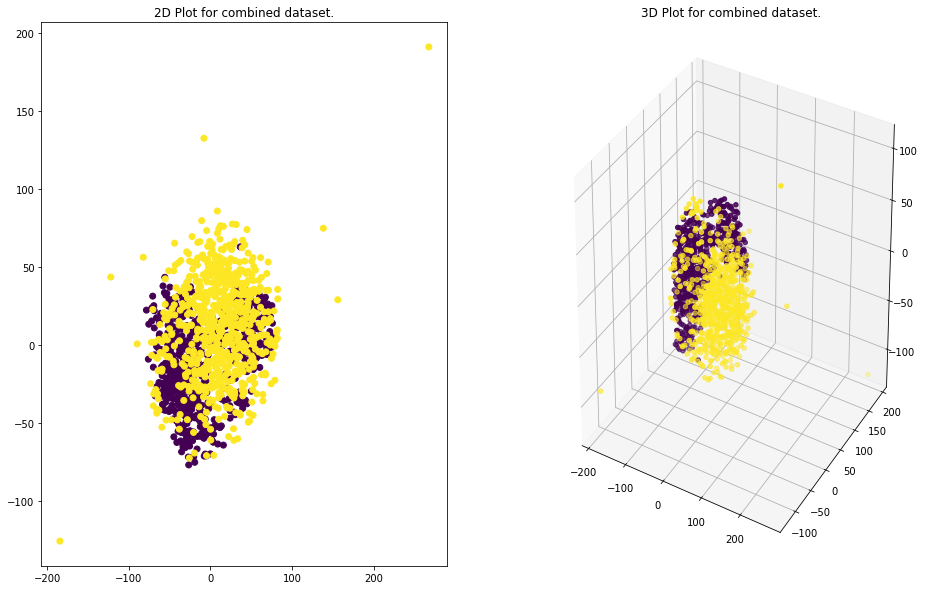

In [537]:
X_TSNE = TSNE(n_components=3).fit_transform(X_kpca)
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 2, 1)
ax.title.set_text("2D Plot for combined dataset.")
ax.scatter(X_TSNE[:,0],X_TSNE[:,1], c=y)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.title.set_text("3D Plot for combined dataset.")
ax.scatter(X_TSNE[:,0],X_TSNE[:,1],X_TSNE[:,2],c=y)

## Isomap for the combined dataset.

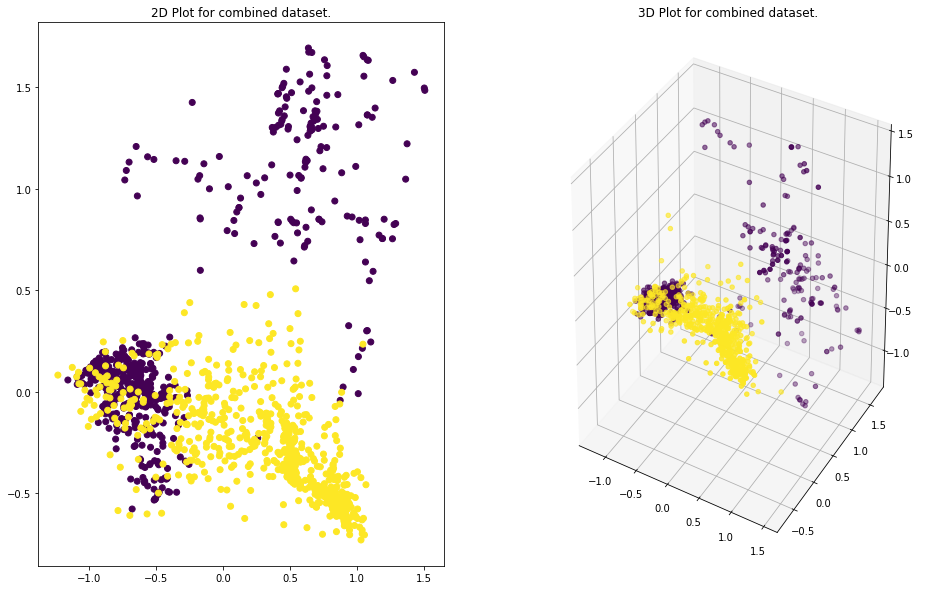

In [538]:
from sklearn.manifold import Isomap
iso = Isomap(n_components=3).fit_transform(X_kpca)
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 2, 1)
ax.title.set_text("2D Plot for combined dataset.")
ax.scatter(iso[:,0],iso[:,1], c=y)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.title.set_text("3D Plot for combined dataset.")
ax.scatter(iso[:,0],iso[:,1],iso[:,2],c=y)

In [565]:
# Create your classifier
# Using the classifiers created above
X_train, X_test, y_train, y_test = train_test_split(X_kpca, y, random_state = 0)
for j, model_name in enumerate(model_names):
    model = models[j]
    model.train(X_train, y_train)
# Validate your classifier
    prediction, cm, accuracy, p, r, f1 = model.validate(X_test, y_test)
    print('Accuracy for ' + model_name, ': ', accuracy)

Accuracy for MLP :  0.964516129032258
Accuracy for Logistic Regression :  0.9258064516129032
Accuracy for SVM :  0.9806451612903225
Accuracy for D-Tree :  0.9258064516129032


#### Using Logistic Regression + Kernel PCA

In [566]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.
model = logistic_reg_model
kf = KFold(n_splits=10, random_state=None, shuffle=False)
itr = 0
print('Accuracy for k-fold cross validation')
bool1 = 0
bool0 = 0
correct = []
incorrect = []
for train_index, test_index in kf.split(X_kpca):
    X_train, X_test = X_kpca[train_index], X_kpca[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.train(X_train, y_train)
    prediction, cm, accuracy, p, r, f1 = model.validate(X_test, y_test)
    print('Iteration: ', itr, ' | Accuracy: ', accuracy)
    itr += 1
    if itr == 10:
        for i, res in enumerate(prediction):
            if bool0 < 5 and res != y_test[i]:
                incorrect.append(i)
                bool0 += 1
            elif bool1 < 5 and res == y_test[i]:
                correct.append(i)
                bool1 += 1

Accuracy for k-fold cross validation
Iteration:  0  | Accuracy:  0.5967741935483871
Iteration:  1  | Accuracy:  0.9758064516129032
Iteration:  2  | Accuracy:  0.9516129032258065
Iteration:  3  | Accuracy:  0.8709677419354839
Iteration:  4  | Accuracy:  0.967741935483871
Iteration:  5  | Accuracy:  0.8951612903225806
Iteration:  6  | Accuracy:  0.9032258064516129
Iteration:  7  | Accuracy:  0.9105691056910569
Iteration:  8  | Accuracy:  0.926829268292683
Iteration:  9  | Accuracy:  0.983739837398374


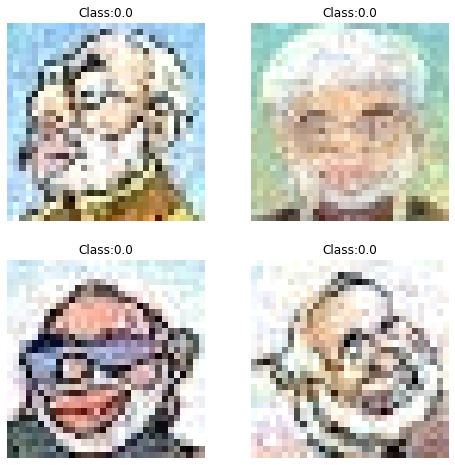

In [574]:
# Show quantitative results such as examples of correct prediction and wrong prediction
correctx = X_test[correct]
X_reconstructed = reconstruct_images(X, correctx, num_features, kpca)

#reshape
X_reconstructed = X_reconstructed.reshape((len(correct), H, W, C))

# Display random images
disply_images(X_reconstructed,y[correct],row=2,col=2)

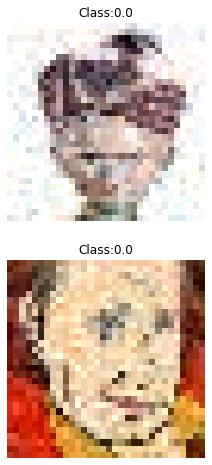

In [575]:
incorrectx = X_test[incorrect]
X_reconstructed = reconstruct_images(X, incorrectx, num_features, kpca)

#reshape
X_reconstructed = X_reconstructed.reshape((len(incorrect), H, W, C))

# Display random images
disply_images(X_reconstructed,y[incorrect],row=len(incorrect),col=1)